In [ ]:
import os, sys
if '..' not in sys.path:
    sys.path.append('..')
    os.chdir('..')

import yaml, torch
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import pandas as pd
import torch

import torchvision.transforms as transforms
# from torchvision.transforms import v2
from sklearn.manifold import TSNE

from src.data_manager import init_data
from src.msn_train import init_model

In [ ]:
VALIDATION = True
directory = 'checkpoint/msn-complete-br-data' 

with open(os.path.join(directory, "params-temperature-exp-1.yaml"), 'r') as y_file:
    params = yaml.load(y_file, Loader=yaml.FullLoader)

INFO:root:data loader created


Text(0.5, 0.98, 'Train samples')

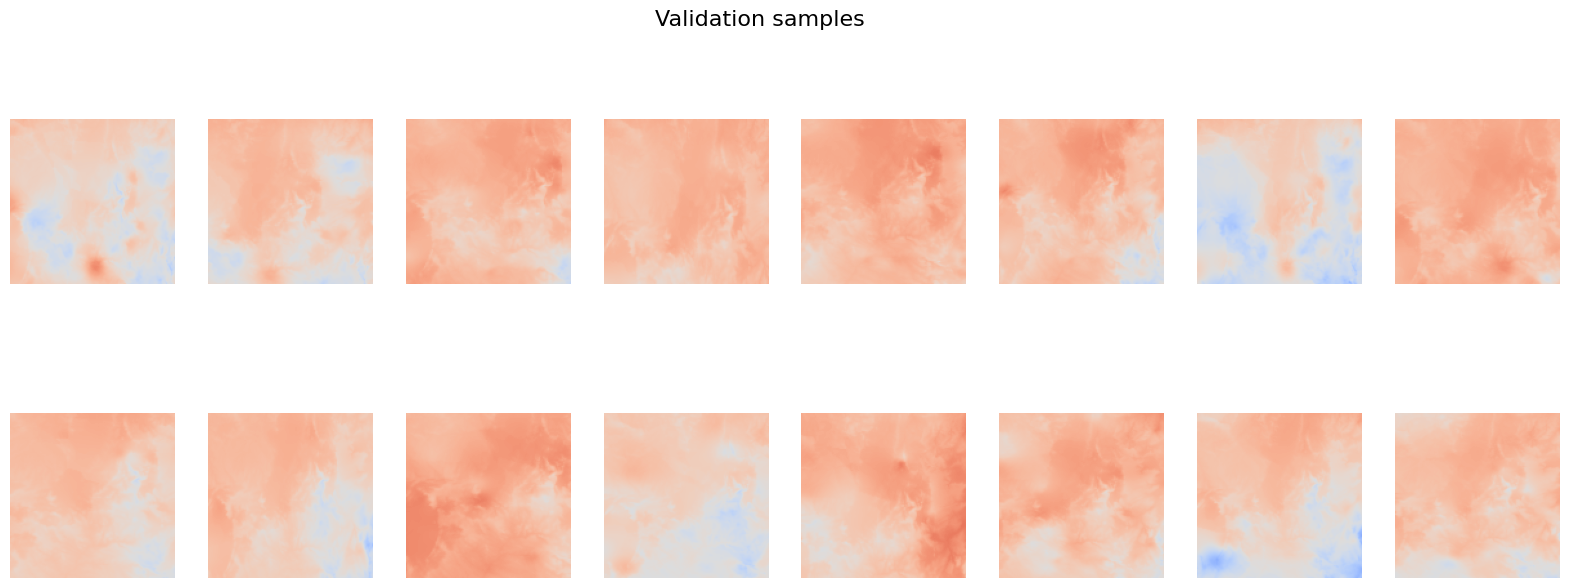

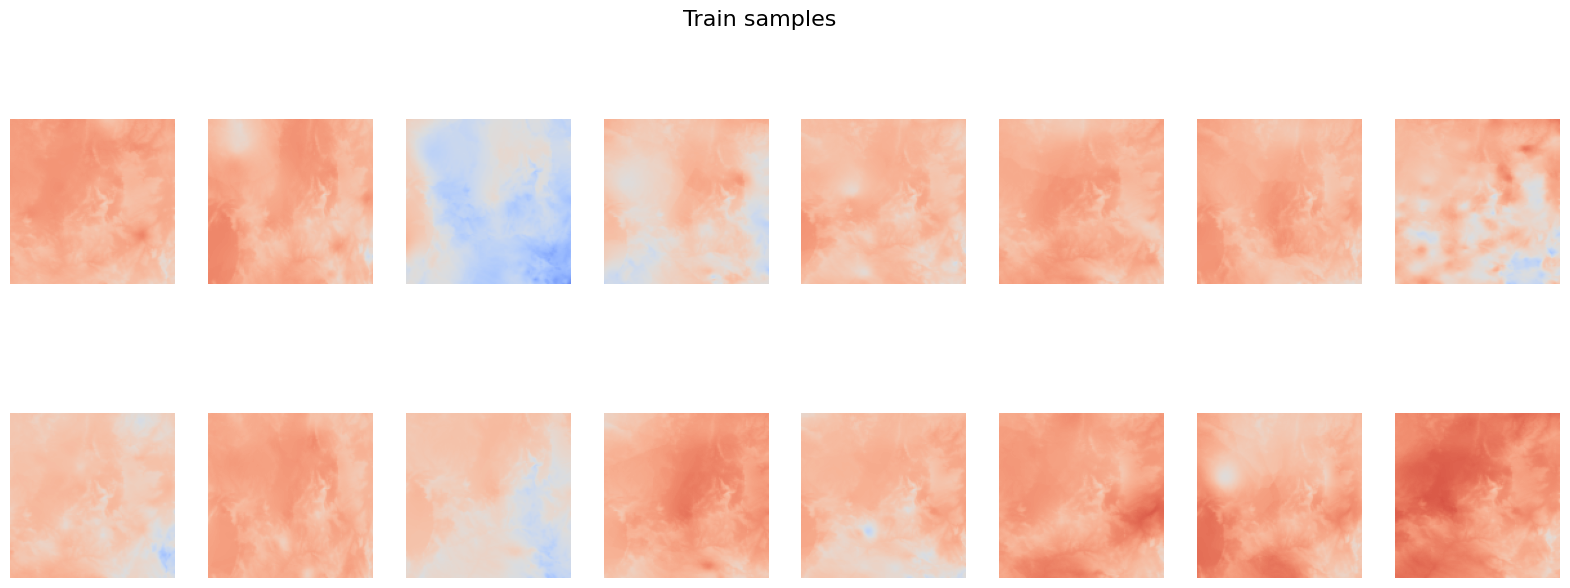

In [ ]:
rand_transform = transforms.Compose([
        transforms.RandomResizedCrop(128, scale=(0.5, 1.0)),
        transforms.Normalize(
            params['data']['norm_means'], #'Tmin', 'Tmax',
            params['data']['norm_stds'])
    ])


(unsupervised_loader, unsupervised_sampler) = init_data(
    transform=rand_transform,
    batch_size=8,
    surf_vars=params['data']['surf_vars'],
    static_vars=params['data']['static_vars'],
    lat_lim=params['data']['lat_limit'], lon_lim=params['data']['lon_limit'],
    split_val = VALIDATION,
    # dataset_samples=1000
)

if VALIDATION:
    random_samples = torch.randint(0, len(unsupervised_loader.dataset.validation_imgs), (8,))
    fig, axes = plt.subplots(2, 8, figsize=(20, 7))

    def get_val_sample(sample):
        return rand_transform(unsupervised_loader.dataset.validation_imgs[sample])

    for i, sample in enumerate(random_samples):
        axes[0, i].imshow(get_val_sample(sample)[0], cmap='coolwarm',vmin=-6.9798,vmax=4.0726)
        axes[0, i].axis("off")
        axes[1, i].imshow(get_val_sample(sample)[1], cmap='coolwarm',vmin= -7.0872,vmax =4.1556)
        axes[1, i].axis("off")
    fig.suptitle('Validation samples', fontsize=16)

images, _ = next(iter(unsupervised_loader))
fig, axes = plt.subplots(2, 8, figsize=(20, 7))

for i in range(8):
    axes[0, i].imshow(images[i][0], cmap='coolwarm',vmin=-6.9798,vmax=4.0726)
    axes[0, i].axis("off")
    axes[1, i].imshow(images[i][1], cmap='coolwarm',vmin= -7.0872,vmax =4.1556)
    axes[1, i].axis("off")
    
fig.suptitle('Train samples', fontsize=16)

In [ ]:
# Create the encoder and load the latest checkpoint

target_encoder = init_model(
    device = "cuda:0",
    model_name = params['meta']['model_name'],
    use_bn = params['meta']['use_bn'],
    hidden_dim = params['meta']['hidden_dim'],
    output_dim = params['meta']['output_dim'],
    drop_path_rate = params['meta']['drop_path_rate'],
)

print(params['logging']['folder'])

latest_checkpoint = os.path.join(params['logging']['folder'], params['logging']['write_tag'] + "-latest.pth.tar")
checkpoint = torch.load(latest_checkpoint, map_location='cpu')

target_encoder.load_state_dict(checkpoint['target_encoder'], strict=False)
target_encoder.eval()

prot = checkpoint['prototypes'].to("cuda:0")
prot = torch.nn.functional.normalize(prot)
# prot.shape

INFO:root:VisionTransformer(
  (patch_embed): PatchEmbed(
    (proj): Conv2d(2, 384, kernel_size=(16, 16), stride=(16, 16))
  )
  (pos_drop): Dropout(p=0.0, inplace=False)
  (blocks): ModuleList(
    (0-11): 12 x Block(
      (norm1): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (attn): Attention(
        (qkv): Linear(in_features=384, out_features=1152, bias=True)
        (attn_drop): Dropout(p=0.0, inplace=False)
        (proj): Linear(in_features=384, out_features=384, bias=True)
        (proj_drop): Dropout(p=0.0, inplace=False)
      )
      (drop_path): Identity()
      (norm2): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
      (mlp): MLP(
        (fc1): Linear(in_features=384, out_features=1536, bias=True)
        (act): GELU(approximate='none')
        (fc2): Linear(in_features=1536, out_features=384, bias=True)
        (drop): Dropout(p=0.0, inplace=False)
      )
    )
  )
  (norm): LayerNorm((384,), eps=1e-06, elementwise_affine=True)
  (fc): Sequent

/tmp/ipykernel_3885217/1708972522.py:15: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(latest_checkpoint, map_location='cpu')


In [ ]:
from tqdm import tqdm

# Encode the images with progress bar
E = torch.empty(0, params['meta']['output_dim']).to("cuda:0")
F = torch.empty(0, prot.shape[0]).to("cuda:0")
L = torch.empty(0).to("cuda:0")

with torch.no_grad():
    for img, lab in tqdm(unsupervised_loader.dataset, desc="Encoding"):
        img = img.unsqueeze(0).to("cuda:0")
        enc = target_encoder(img)
        enc = torch.nn.functional.normalize(enc)
        E = torch.cat((E, enc), 0)
        F = torch.cat((F, enc @ prot.T), 0)
        L = torch.cat((L, lab.unsqueeze(0).to("cuda:0")), 0)

print(E.shape, F.shape, L.shape)

Encoding: 100%|██████████| 22358/22358 [03:13<00:00, 115.67it/s]

torch.Size([22358, 128]) torch.Size([22358, 60]) torch.Size([22358])


In [ ]:
if VALIDATION:
    # Encode the images with progress bar
    E_val = torch.empty(0, params['meta']['output_dim']).to("cuda:0")
    F_val = torch.empty(0, prot.shape[0]).to("cuda:0")

    with torch.no_grad():
        for img in tqdm(unsupervised_loader.dataset.validation_imgs, desc="Encoding"):
            img = rand_transform(img)
            img = img.unsqueeze(0).to("cuda:0")
            enc = target_encoder(img)
            enc = torch.nn.functional.normalize(enc)
            E_val = torch.cat((E_val, enc), 0)
            F_val = torch.cat((F_val, enc @ prot.T), 0)

    print(E_val.shape, F_val.shape)

    data = torch.cat((E.cpu(), E_val.cpu(), prot.cpu()), dim=0).numpy()

    # Apply TSNE
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(data)

    # Separate the results for prototypes and latent points
    tsne_E = tsne_results[:E.shape[0]]
    tsne_Eval = tsne_results[E.shape[0]:E.shape[0]+E_val.shape[0]]
    tsne_prot = tsne_results[E.shape[0]+E_val.shape[0]:]

else:
    data = torch.cat((E.cpu(), prot.cpu()), dim=0).numpy()

    # Apply TSNE
    tsne = TSNE(n_components=2)
    tsne_results = tsne.fit_transform(data)

    # Separate the results for prototypes and latent points
    tsne_E = tsne_results[:E.shape[0]]
    tsne_prot = tsne_results[E.shape[0]:]

Encoding: 100%|██████████| 732/732 [00:06<00:00, 118.67it/s]


torch.Size([732, 128]) torch.Size([732, 60])


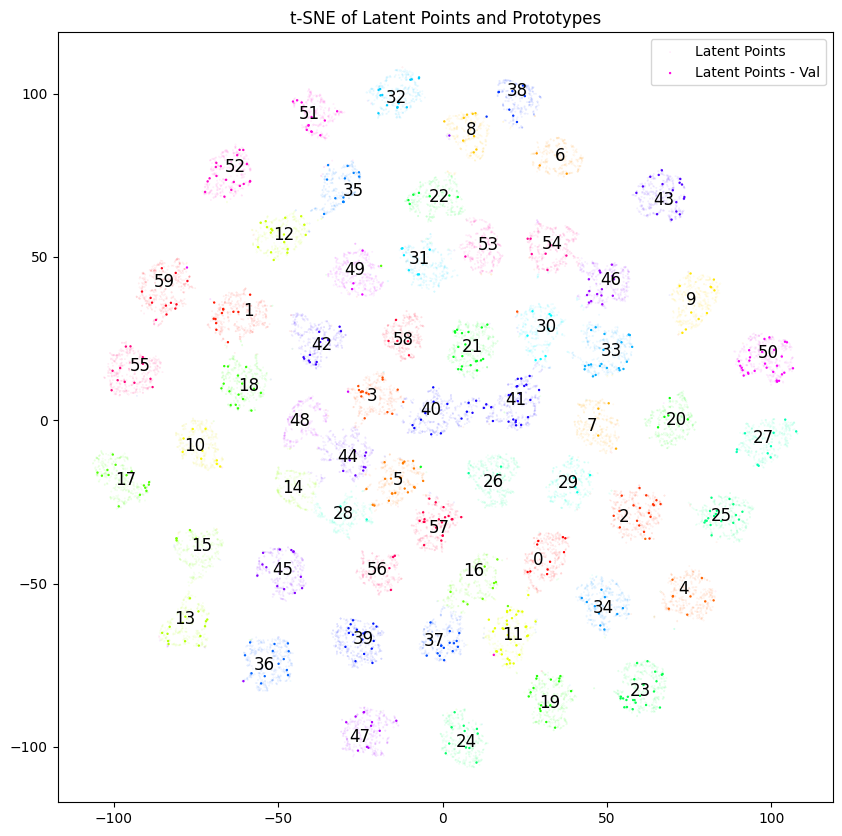

In [ ]:
# Plot the TSNE results

plt.figure(figsize=(10, 10))
if VALIDATION:
    
    cluster_labels = F.argmax(axis=1).cpu().numpy()
    plt.scatter(tsne_E[:, 0], tsne_E[:, 1],   c= cluster_labels, cmap='hsv',  label='Latent Points', s=0.1,alpha=0.1)
    
    cluster_labels = F_val.argmax(axis=1).cpu().numpy()
    plt.scatter(tsne_Eval[:, 0], tsne_Eval[:, 1], c= cluster_labels, cmap='hsv', label='Latent Points - Val', s=0.5)
else:
    cluster_labels = F.argmax(axis=1).cpu().numpy()
    plt.scatter(tsne_E[:, 0], tsne_E[:, 1], c= cluster_labels, cmap='hsv', label='Latent Points', s=0.2)
    

# plt.scatter(tsne_prot[:, 0], tsne_prot[:, 1], c='black', label='Prototypes', marker='.')
for i, (x, y) in enumerate(tsne_prot):
    plt.text(x, y, i, color='black', fontsize=12, ha='center', va='center')

plt.legend()
plt.title("t-SNE of Latent Points and Prototypes")
plt.show()

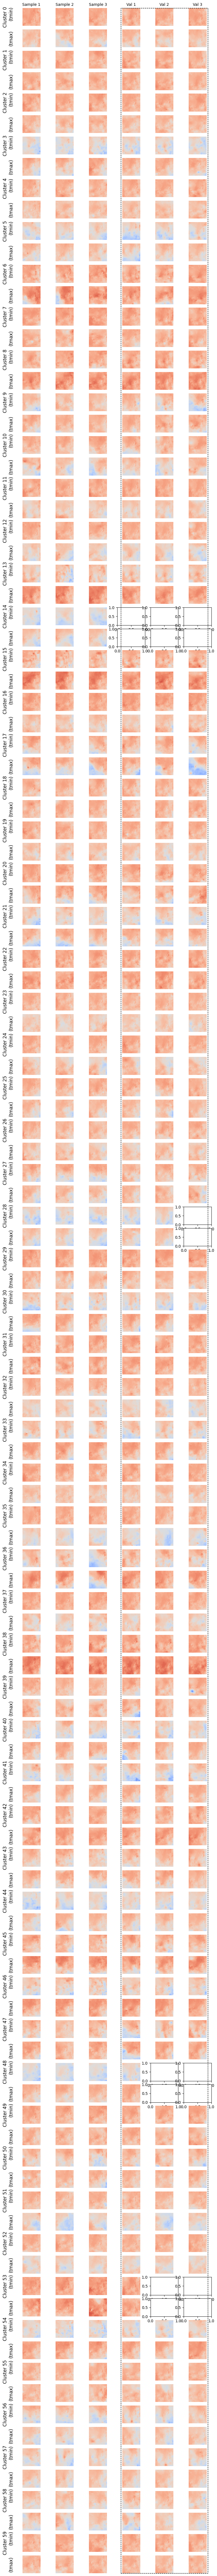

In [ ]:
Top = 3

max_val, max_idx = torch.max(F, dim=1) # Obtém os valores máximos e seus índices
df = pd.DataFrame({"max_idx": max_idx.cpu(), "max_val": max_val.cpu()})

if VALIDATION:
    max_val, max_idx = torch.max(F_val, dim=1)
    df_val = pd.DataFrame({"max_idx": max_idx.cpu(), "max_val": max_val.cpu()})
    fig, axes = plt.subplots(params['criterion']['num_proto']*2, Top * 2, figsize=(Top * 3, params['criterion']['num_proto'] * 2)) 

else:
    fig, axes = plt.subplots(params['criterion']['num_proto']*2, Top, figsize=(Top , params['criterion']['num_proto'])) 

    fig.suptitle("Top Samples from Each Cluster (tmin and tmax)", fontsize=16) # Título geral da figura


row_n = 0
for i in range(params['criterion']['num_proto']):
    
    top_samples = df[df["max_idx"] == i].nlargest(Top, "max_val")

    for j, im_index in enumerate(top_samples.index):
        image_data = unsupervised_loader.dataset[im_index][0]

        ax_tmin = axes[row_n, j]
        ax_tmin.imshow(image_data[0], cmap='coolwarm', vmin=-6.9798, vmax=4.0726)
        ax_tmin.axis("off")
        if i == 0: # Adiciona título da coluna apenas na primeira linha
            ax_tmin.set_title(f"Sample {j+1}", fontsize=10)
            
        ax_tmax = axes[row_n+1, j] # Correção do índice para a segunda dimensão
        ax_tmax.imshow(image_data[1], cmap='coolwarm', vmin=-7.0872, vmax=4.1556)
        ax_tmax.axis("off")

    if VALIDATION:
        top_samples = df_val[df_val ["max_idx"] == i].nlargest(Top, "max_val")

        for j, im_index in enumerate(top_samples.index):
            image_data = rand_transform(unsupervised_loader.dataset.validation_imgs[im_index])

            ax_tmin = axes[row_n, j+Top]
            ax_tmin.imshow(image_data[0], cmap='coolwarm', vmin=-6.9798, vmax=4.0726)
            ax_tmin.axis("off")
            if i == 0: 
                ax_tmin.set_title(f"Val {j+1}", fontsize=10)
                
            ax_tmax = axes[row_n+1, j+Top] 
            ax_tmax.imshow(image_data[1], cmap='coolwarm', vmin=-7.0872, vmax=4.1556)
            ax_tmax.axis("off")


        # Adicionar título para cada linha de cluster
    axes[row_n, 0].text(-0.5, 0.5, f"Cluster {i}\n(tmin)", transform=axes[row_n, 0].transAxes,
                    fontsize=12, va='center', ha='right', rotation=90)

    axes[row_n+1, 0].text(-0.5, 0.5, f"(tmax)", transform=axes[row_n+1, 0].transAxes,
                    fontsize=12, va='center', ha='right', rotation=90)
    
    row_n += 2

top_left_ax = axes[0, Top]
bottom_right_ax = axes[-1, Top - 1]

# Coordenadas no sistema da figura
x0 = top_left_ax.get_position().x0
y0 = bottom_right_ax.get_position().y0
x1 =  axes[0, -1].get_position().x1
y1 = top_left_ax.get_position().y1

# Cria o retângulo
rect = patches.Rectangle(
    (x0-0.005, y0), (x1 - x0)+0.01, (y1 - y0),
    transform=fig.transFigure, fill=False,
    color='black', linewidth=1, linestyle='dashed'
)

fig.patches.append(rect)
# plt.tight_layout() # Ajusta o layout para evitar sobreposição, deixando espaço para o título geral
plt.show()

Plot groups distributions according to weather seasons  /patterns

In [ ]:
import numpy as np

max_val, max_idx = torch.max(F, dim=1) # Obtém os valores máximos e seus índices
df = pd.DataFrame({"max_idx": max_idx.cpu(), "max_val": max_val.cpu()})
times_index = pd.to_datetime(unsupervised_loader.dataset.time)

if VALIDATION:
    times_index = times_index[ np.where(~times_index.year.isin([1980, 2000]))[0]]

df.index = times_index
df.tail()

max_idx   max_val
2024-03-16       53  0.951879
2024-03-17       53  0.974251
2024-03-18       53  0.962085
2024-03-19       53  0.964732
2024-03-20       29  0.894438

In [ ]:
def get_season(date):
    month = date.month
    day = date.day

    # Verão: 21 ou 22 de dezembro a 20 ou 21 de março
    if (month == 12 and day >= 21) or \
       (month == 1 or month == 2) or \
       (month == 3 and day <= 20):
        return 'Verão'
    # Outono: 20 ou 21 de março a 20 ou 21 de junho
    elif (month == 3 and day >= 21) or \
         (month == 4 or month == 5) or \
         (month == 6 and day <= 20):
        return 'Outono'
    # Inverno: 20 ou 21 de junho a 22 ou 23 de setembro
    elif (month == 6 and day >= 21) or \
         (month == 7 or month == 8) or \
         (month == 9 and day <= 22):
        return 'Inverno'
    # Primavera: 22 ou 23 de setembro a 20 ou 21 de dezembro
    else: # (month == 9 and day >= 23) or (month == 10 or month == 11) or (month == 12 and day <= 20)
        return 'Primavera'

# Aplique a função para criar uma nova coluna 'season'
df['season'] = df.index.to_series().apply(get_season)

In [ ]:
season_cluster_distribution = pd.crosstab(df['season'], df['max_idx'])
season_cluster_distribution

max_idx     0    1    2    3    4    5    6    7    8    9   ...   50   51  \
season                                                       ...             
Inverno      0    0    0  317    1  192   38    2  109  133  ...   22    0   
Outono      56   82   84   17   69  146    5   63    2  275  ...  379   55   
Primavera  179   57   96    0   72    0  270  138  222   13  ...   11  106   
Verão      156  280  212    0  272    0    7  169    2    5  ...    1  146   

max_idx     52   53   54   55   56   57   58   59  
season                                             
Inverno      0    1  369    2   69   71   34    0  
Outono      37   20    0   77  208  289  258   78  
Primavera   90  172    0   53    9    0   38   97  
Verão      249  139    0  309    5    1   17  259  

[4 rows x 60 columns]

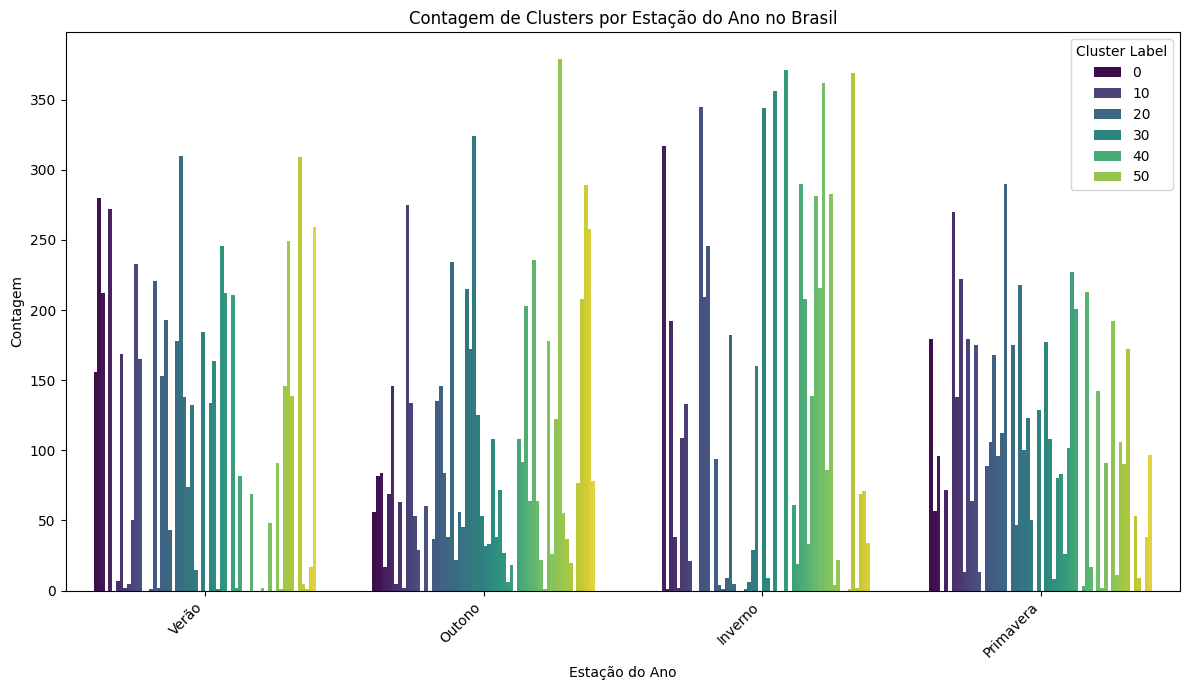

In [ ]:
import seaborn as sns

plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='season', hue='max_idx',  palette='viridis')
plt.title('Contagem de Clusters por Estação do Ano no Brasil')
plt.xlabel('Estação do Ano')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster Label')
plt.tight_layout()
plt.show()


In [ ]:
# https://www.climate.gov/news-features/understanding-climate/climate-variability-oceanic-nino-index
oni_index = pd.read_excel('data/oni_index.xlsx')
oni_index.set_index('Year', inplace=True)
oni_index.columns.name='Month'
oni_index.columns = range(1,13)
oni_index= oni_index.unstack().to_frame('ONI')
oni_index['date_period'] = pd.to_datetime(oni_index.index.map(lambda x: f"{x[1]}-{x[0]}-01")).to_period('M')
oni_index.set_index('date_period', inplace=True)

oni_index =oni_index[oni_index.index.year>=1961]

oni_index.loc[oni_index['ONI'] > 0.5,'Label'] = 'El Niño'
oni_index.loc[oni_index['ONI'] < -0.5,'Label'] = 'La Niña'
oni_index.loc[oni_index['ONI'].between(-0.5, 0.5), 'Label'] = 'Neutro'

In [ ]:
df['period']= df.index.to_period('M')
df = df.merge(oni_index[['Label']], left_on='period', right_index=True, how='left')
df.head()

max_idx   max_val season   period   Label
1961-01-01       52  0.941357  Verão  1961-01  Neutro
1961-01-02       10  0.864240  Verão  1961-01  Neutro
1961-01-03       52  0.883865  Verão  1961-01  Neutro
1961-01-04       51  0.961681  Verão  1961-01  Neutro
1961-01-05       52  0.879678  Verão  1961-01  Neutro

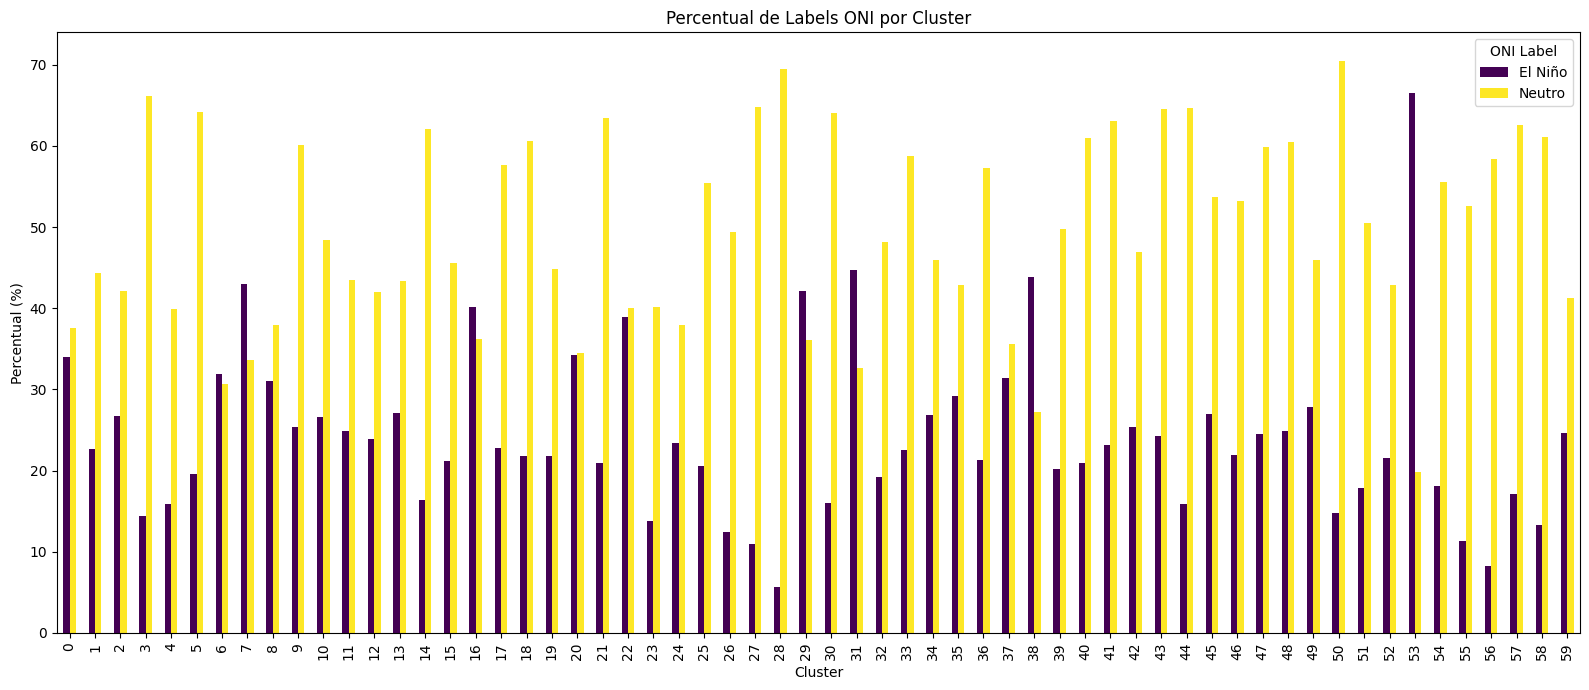

In [ ]:
#bar plot 
#max_idx vs Label
# Calculate percentual count for each label within each cluster
percent_df = (
    df.groupby(['max_idx', 'Label'])
    .size()
    .groupby(level=0)
    .apply(lambda x: 100 * x / x.sum())
    .unstack(fill_value=0)
    .droplevel(0)
)



# # Plot
percent_df.drop(columns=['La Niña']).plot(kind='bar', stacked=False, figsize=(16, 7), colormap='viridis')
plt.ylabel('Percentual (%)')
plt.xlabel('Cluster')
plt.title('Percentual de Labels ONI por Cluster')
plt.legend(title='ONI Label')
plt.tight_layout()
plt.show()

In [ ]:
df

max_idx   max_val season   period    Label
1961-01-01       52  0.941357  Verão  1961-01   Neutro
1961-01-02       10  0.864240  Verão  1961-01   Neutro
1961-01-03       52  0.883865  Verão  1961-01   Neutro
1961-01-04       51  0.961681  Verão  1961-01   Neutro
1961-01-05       52  0.879678  Verão  1961-01   Neutro
...             ...       ...    ...      ...      ...
2024-03-16       53  0.951879  Verão  2024-03  El Niño
2024-03-17       53  0.974251  Verão  2024-03  El Niño
2024-03-18       53  0.962085  Verão  2024-03  El Niño
2024-03-19       53  0.964732  Verão  2024-03  El Niño
2024-03-20       29  0.894438  Verão  2024-03  El Niño

[22358 rows x 5 columns]

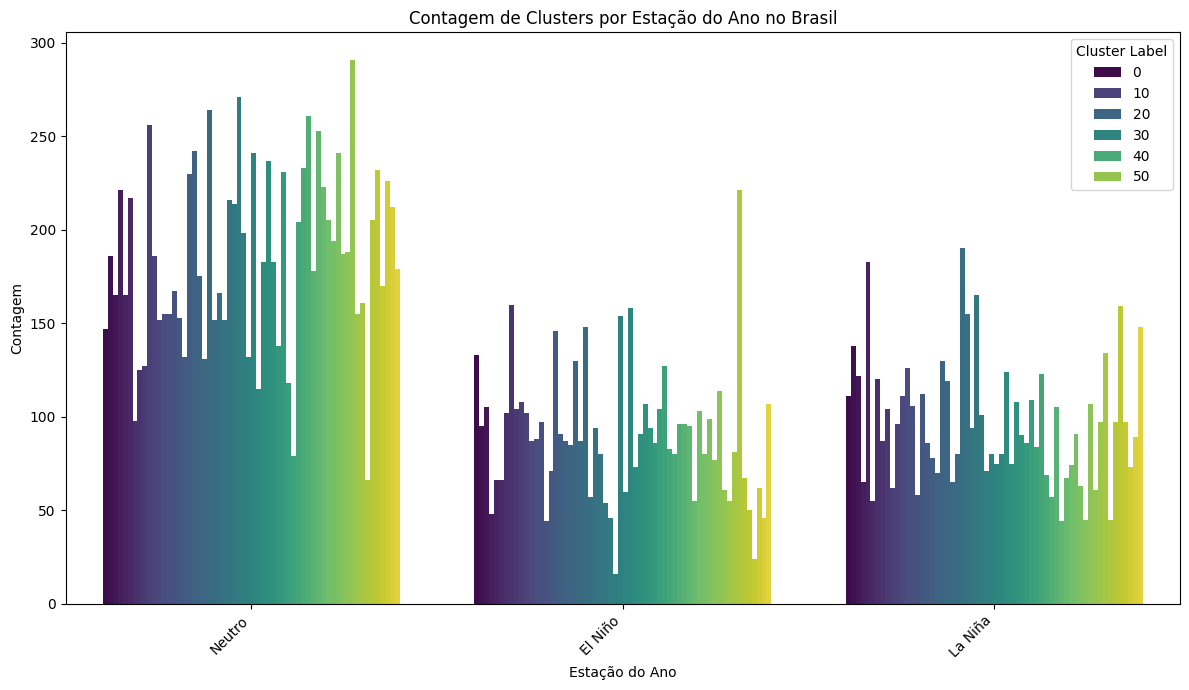

In [ ]:

plt.figure(figsize=(12, 7))
sns.countplot(data=df, x='Label', hue='max_idx', palette='viridis')
plt.title('Contagem de Clusters por Estação do Ano no Brasil')
plt.xlabel('Estação do Ano')
plt.ylabel('Contagem')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster Label')
plt.tight_layout()
plt.show()


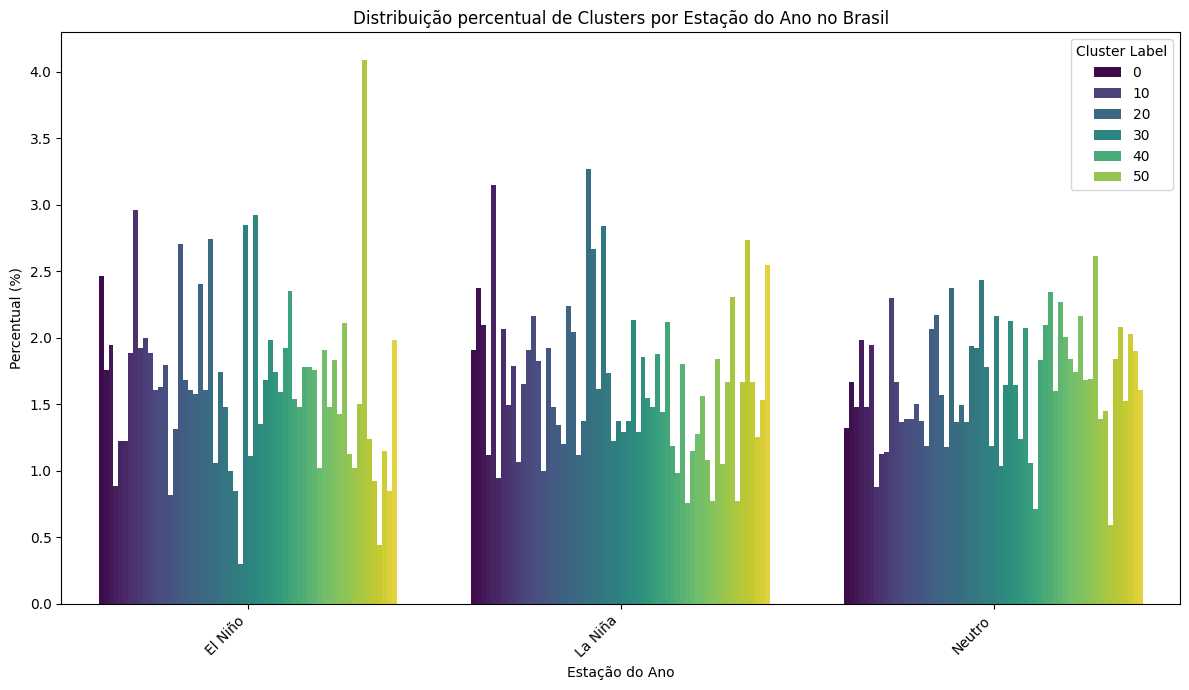

In [ ]:
group_counts = df.groupby(['Label', 'max_idx']).size().reset_index(name='count')
group_totals = group_counts.groupby('Label')['count'].transform('sum')
group_counts['percent'] = group_counts['count'] / group_totals * 100

# 3. Plot as percentage barplot
plt.figure(figsize=(12, 7))
sns.barplot(data=group_counts, x='Label', y='percent', hue='max_idx', palette='viridis')

plt.title('Distribuição percentual de Clusters por Estação do Ano no Brasil')
plt.xlabel('Estação do Ano')
plt.ylabel('Percentual (%)')
plt.xticks(rotation=45, ha='right')
plt.legend(title='Cluster Label')
plt.tight_layout()
plt.show()

## Tentar agrupar os clusters e ver um padrão mais claro de deslocamento

In [ ]:
from scipy.spatial.distance import pdist, squareform
import plotly.graph_objects as go
centroides = prot.cpu()
dist_matrix = squareform(pdist(centroides, metric='euclidean'))

dist_matrix = pd.DataFrame(
    dist_matrix,
    index=range(prot.shape[0]),
    columns=range(prot.shape[0])
)

mask = np.eye(len(dist_matrix), dtype=bool)
dist_matrix_no_diag = dist_matrix.copy()
dist_matrix_no_diag.values[mask] = np.nan

fig = go.Figure(data=go.Heatmap(
    z=dist_matrix_no_diag.values,
    x=dist_matrix.columns.astype(str),
    y=dist_matrix.index.astype(str),
    colorscale='Viridis',
    colorbar=dict(title='Distância Euclidiana'),
    hovertemplate='Cluster X: %{x}<br>Cluster Y: %{y}<br>Distância: %{z:.2f}<extra></extra>'
))

fig.update_layout(
    title='Matriz de Distâncias entre Centróides (sem diagonal)',
    xaxis_title='Cluster',
    yaxis_title='Cluster',
    width=1200,
    height=900
)

fig.show()

range(0, 60)

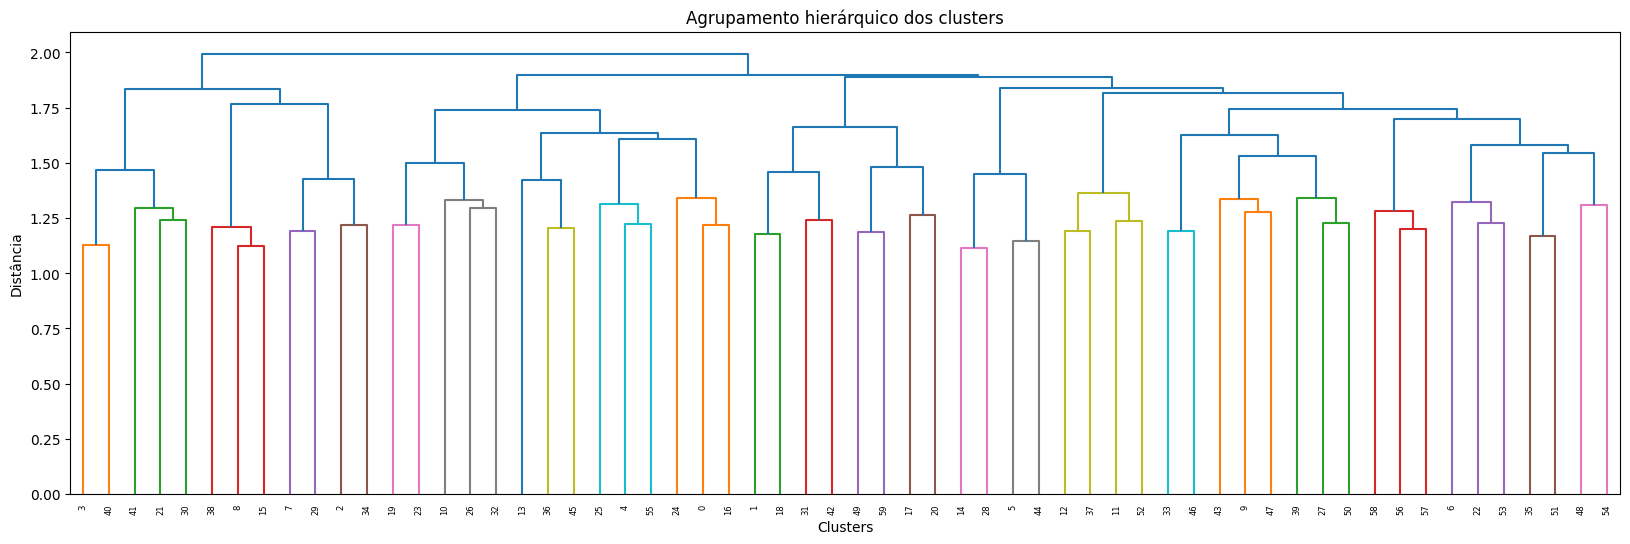

In [ ]:
from scipy.cluster.hierarchy import linkage, fcluster, dendrogram
import matplotlib.pyplot as plt

Z = linkage(centroides, method='ward')
# Plotando o dendrograma
plt.figure(figsize=(20, 6))
dendrogram(Z, labels=range(centroides.shape[0]), leaf_rotation=90)
plt.title("Agrupamento hierárquico dos clusters")
plt.xlabel("Clusters")
plt.ylabel("Distância")
plt.show()

INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
INFO:matplotlib.category:Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


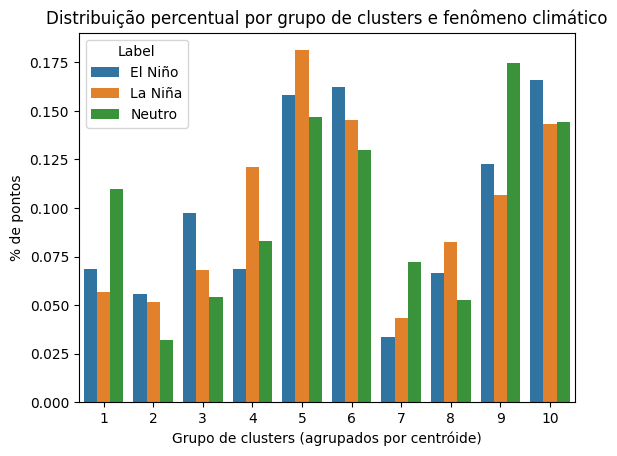

In [ ]:
grupo_clusters = fcluster(Z, t=25, criterion='maxclust')
df['grupo_cluster'] = df['max_idx'].map(dict(zip(range(centroides.shape[0]), grupo_clusters)))


plot_df = df.groupby(['Label', 'grupo_cluster']).size()
plot_df = plot_df.groupby(level=0).apply(lambda x: x / x.sum())\
    .droplevel(0).reset_index(name='percentual')
    
sns.barplot(data=plot_df, x='grupo_cluster', y='percentual', hue='Label')
plt.title('Distribuição percentual por grupo de clusters e fenômeno climático')
plt.ylabel('% de pontos')
plt.xlabel('Grupo de clusters (agrupados por centróide)')
plt.show()